# Blind Machine Learning

This notebook is the final answer to the first of the two questions contained in NextCaller's Data Science Quiz (a blind machine learning problem). I summarize the answers here and explain the rest below.

To recap the answer given below: all of my analysis suggests that the data and classification are random, with Features 1, 2 and 3 drawn from a normal distribution and Feature 4 from a smooth, even distribution. In other words, I assert the data is crap :)

Given the cost function and reward provided and the fact that none of the models make skilful predictions, I show that the best strategy given the listed constraints is to always predict red, with an expected value per prediction of -12.83, and I show with bootstrapping that the 95% confidence interval is -13.1256050775 to -12.5130285417.

In [100]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import datasets
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.utils import resample
import time

%matplotlib inline

# Exploring the Data

In [2]:
data = pd.read_table('Search_Data.txt')
data.head()

,ID,Feat 1,Feat 2,Feat 3,Feat 4,Label
0,1,10.526413,5.680796,1.661569,0.167528,Burnt Umber
1,2,15.023991,5.471672,0.897001,0.669878,Red
2,3,16.021447,-1.501333,1.902509,0.351208,Red
3,4,14.425902,6.429031,1.025405,0.528408,Aquamarine
4,5,11.547150,-4.699529,0.337308,0.011619,Red


In [3]:
data['Label'].value_counts()

Red            720
Aquamarine     220
Burnt Umber     60
Name: Label, dtype: int64

Let's break up the data into independent and dependent variables, and pre-emptively normalize the data so that methods like k-nearest neighbors and logistic regression work properly. Also, I'm going to refer to Burnt Umber as Orange for plotting purposes below.

In [4]:
X = data[['Feat 1','Feat 2','Feat 3','Feat 4']]
Y = data['Label']
Y[Y == 'Burnt Umber'] = 'Orange'

## scale data
standard_scaler = preprocessing.StandardScaler()
X_sc = standard_scaler.fit_transform(X)

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


First, let's plot the relation between each variable to see if any clusters stand out. We normalize the data first to keep plotting axes consistent.

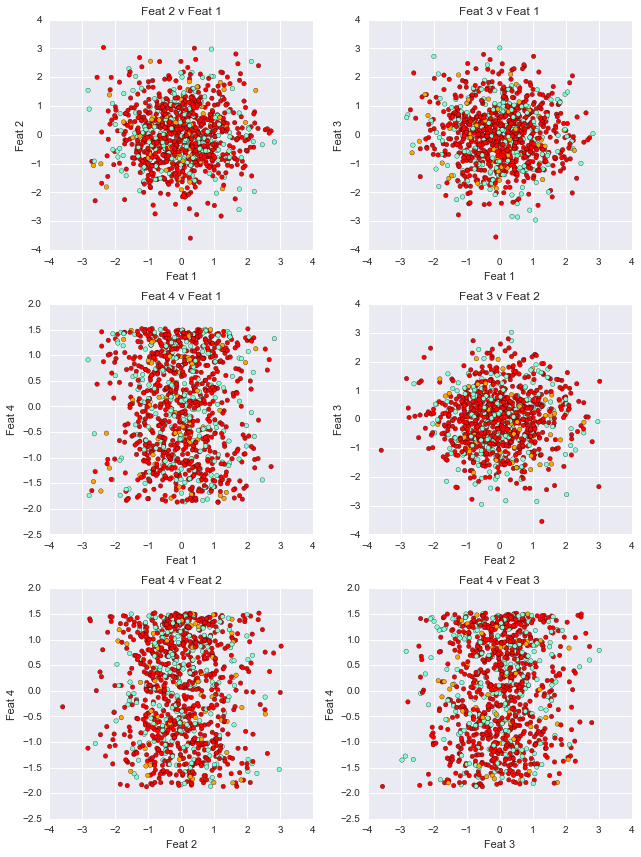

In [5]:
## create one big figure behind subpanels
fig, axes = plt.subplots(3,2,figsize=(9,12), facecolor='w')
pairs = [[0,1],[0,2],[0,3],[1,2],[1,3],[2,3]]
feats = ['Feat 1','Feat 2','Feat 3','Feat 4']


## cycle through each pair of variables and show scatter plot
for ax, pair in zip(axes.reshape(-1),pairs):
    
    ax.scatter(X_sc[:, pair[0]], X_sc[:, pair[1]], c=Y, edgecolors='k', cmap=plt.cm.Paired)
    ax.set_xlabel(feats[pair[0]])
    ax.set_ylabel(feats[pair[1]])
    ax.set_title(feats[pair[1]] + ' v ' + feats[pair[0]])
    
    
plt.tight_layout()

Variables 1, 2 and 3 all look normally distributed with no correlation (as assessed by gunshot plots above), while Variable 4 looks like some kind of smooth distribution cutoff at -2 and 1.5 std devs for min and max respectively.

Let's show a similar plot for each of the types individually.

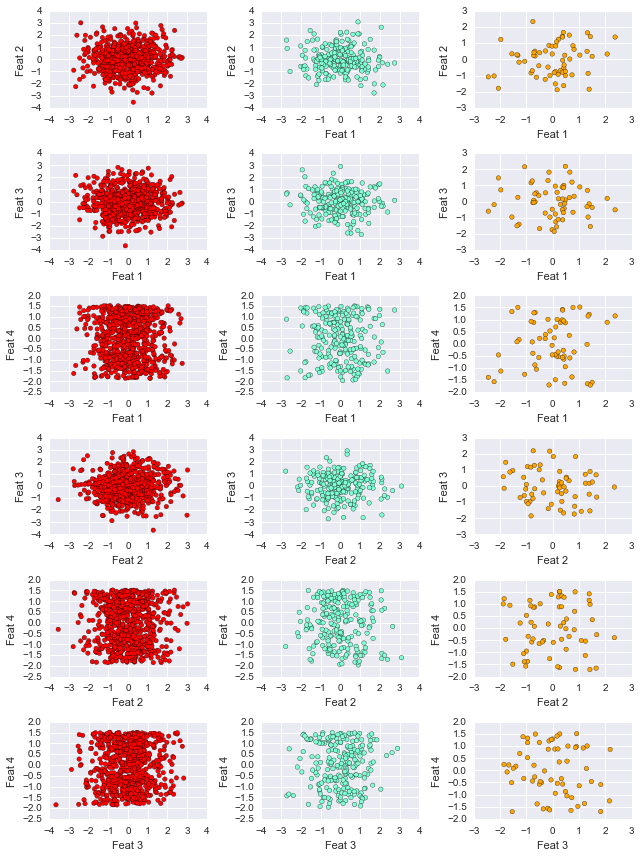

In [6]:
fig, axes = plt.subplots(6,3,figsize=(9,12), facecolor='w')

## create one big figure behind subpanels
pairs_list = [[0,1],[0,2],[0,3],[1,2],[1,3],[2,3]]
pairs = [val for val in pairs_list for __ in range(3)]

df_red = data[data['Label'] == 'Red']
df_aqua = data[data['Label'] == 'Aquamarine']
df_umber = data[data['Label'] == 'Orange']

dflist = [df_red, df_aqua, df_umber]
dfindices = [0,1,2]*6

## cycle through each pair of variables and show scatter plot
for ax, pair, index in zip(axes.reshape(-1),pairs,dfindices):

    ## scale data
    X_color = dflist[index][['Feat 1','Feat 2','Feat 3','Feat 4']]
    standard_scaler = preprocessing.StandardScaler()
    X_color_sc = standard_scaler.fit_transform(X_color)
    ax.scatter(X_color_sc[:, pair[0]], X_color_sc[:, pair[1]], c=dflist[index]['Label'], edgecolors='k', cmap=plt.cm.Paired)
    ax.set_xlabel(feats[pair[0]])
    ax.set_ylabel(feats[pair[1]])
    #ax.set_title(feats[pair[1]] + ' v ' + feats[pair[0]])    
    
plt.tight_layout()

A closer inspection at the distribution of the features for each individual category fails to reveal any major differences between categories. Let's try one more way to explore the data using density plots instead of plotting each individual point.

In [7]:
#switch the category name back to its original
Y[Y == 'Orange'] = 'Burnt Umber'

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


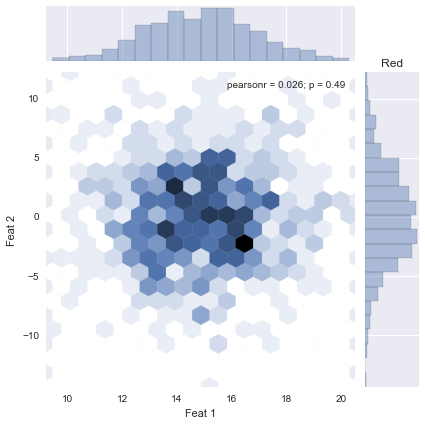

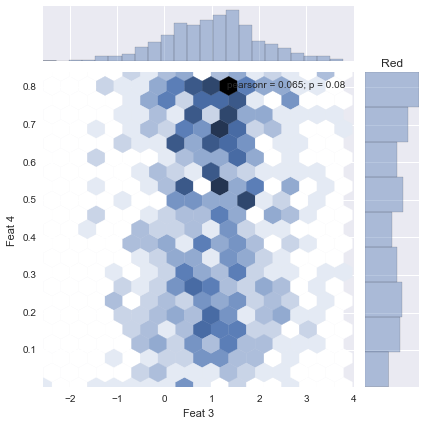

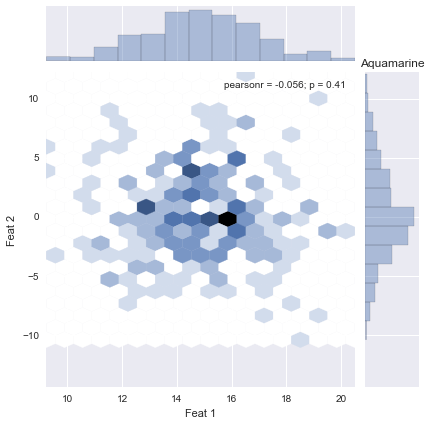

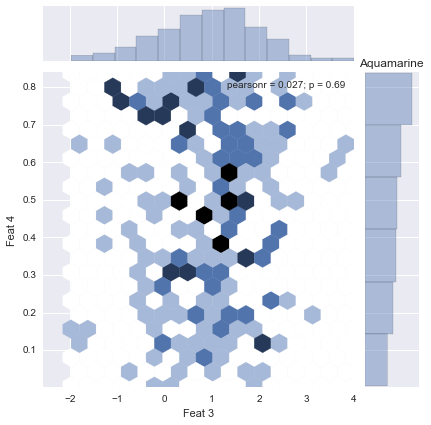

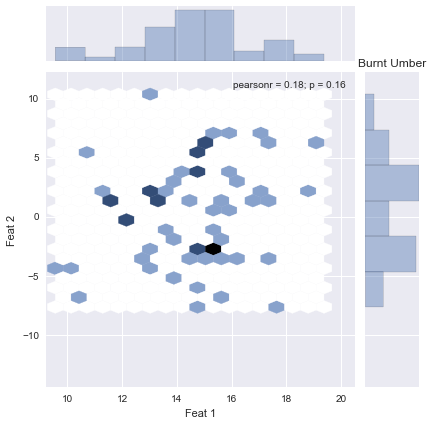

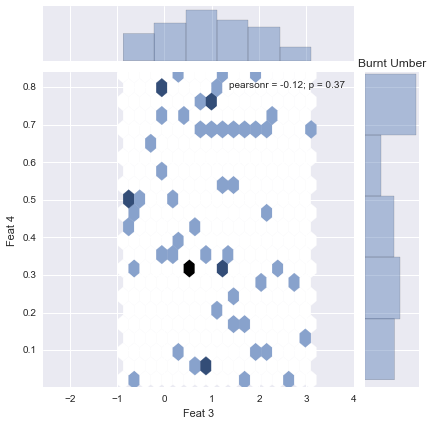

In [8]:
feats = [['Feat 1','Feat 2'],['Feat 3','Feat 4']]*3
df_red = data[data['Label'] == 'Red']
df_aqua = data[data['Label'] == 'Aquamarine']
df_umber = data[data['Label'] == 'Burnt Umber']
df_colors = [df_red,df_red,df_aqua,df_aqua,df_umber,df_umber]
colors = ['Red','Red','Aquamarine','Aquamarine','Burnt Umber','Burnt Umber']
xmin = [data['Feat 1'].min(),data['Feat 2'].min(),data['Feat 3'].min(),data['Feat 4'].min()]
xmax = [data['Feat 1'].max(),data['Feat 2'].max(),data['Feat 3'].max(),data['Feat 4'].max()]
xmin_plot = [xmin[0],xmin[2]]*3
ymin_plot = [xmin[1],xmin[3]]*3
xmax_plot = [xmax[0],xmax[2]]*3
ymax_plot = [xmax[1],xmax[3]]*3

## cycle through each numeric variable and logistic regress with cancellation (excluding cancellation itself)
for i in range(6):
    sns.jointplot(x=feats[i][0], y=feats[i][1], data=df_colors[i], kind = 'hex', \
                  gridsize = [17,11], xlim=[xmin_plot[i],xmax_plot[i]], ylim = [ymin_plot[i],ymax_plot[i]])
    plt.title(colors[i])

From the distribution above, features 1, 2 and 3 really do look normal for all intents and purposes in both the Red and Aquamarine points. The Burnt Umber points are much fewer but also appear to be drawn from the same distribution. The distribution of feature 4 also looks pretty much the same between Red, Aquamarine and Burnt Umber points, but perhaps there is some bimodality in Feature 4 for the Burnt Umber that is absent from Aquamarine - would take a great deal more convincing.

I tried out some other hex plots in my scratch notebook but found nothing worth reporting, so I've omitted other hex plots here with 1v3/2v4 and 1v4/2v3.

Lastly, let's see if the numbers concur with the visual representations of the data above.

In [9]:
data.groupby('Label').describe()

Feat 1      Feat 2      Feat 3      Feat 4           ID
Label                                                                         
Aquamarine  count  220.000000  220.000000  220.000000  220.000000   220.000000
            mean    14.855971    0.245400    0.921365    0.475640   545.463636
            std      2.061649    3.830420    1.069576    0.241026   284.039861
            min      9.234888  -10.352880   -1.972700    0.004776     4.000000
            25%     13.563115   -2.144795    0.264810    0.274100   319.750000
            50%     14.889972   -0.102656    0.985837    0.492571   571.000000
            75%     16.181939    2.830191    1.664535    0.696206   774.500000
            max     20.503973   12.080668    4.012365    0.837411  1000.000000
Burnt Umber count   60.000000   60.000000   60.000000   60.000000    60.000000
            mean    14.553468    0.427304    0.951305    0.452606   540.466667
            std      2.055059    4.291880    0.992022    0.255030   318.406864
            min      9.561882   -7.590026   -0.872921    0.021129     1.000000
            25%     13.173389   -3.099117    0.265904    0.301460   271.000000
            50%     14.809979    1.273276    0.918067    0.459028   503.500000
            75%     15.522447    3.264899    1.638239    0.687479   856.500000
            max     19.378450   10.387722    3.095657    0.835528   991.000000
Red         count  720.000000  720.000000  720.000000  720.000000   720.000000
            mean    14.890096    0.041519    1.017993    0.463451   483.430556
            std      1.974222    4.070017    0.981846    0.248816   286.294805
            min      9.460855  -14.343677   -2.563343    0.002455     2.000000
            25%     13.492842   -2.707882    0.360407    0.243421   233.750000
            50%     14.943531   -0.076003    1.052036    0.481762   477.500000
            75%     16.269048    2.801496    1.605870    0.695670   735.500000
            max     20.306380   12.311362    3.785691    0.841278   997.000000

The means and standard deviations of each of these variables are all pretty close to one another. No population stands out. For instance, let's look at Feature 1 - to approximate the significance of differences in means, the standard deviation of mean is equal to sigma/N^.5. The change in mean between red and burnt umber populations is 14.89-14.55 = .34, std of mean for red is 1.97/(720^.5) = .073, std of mean for umber is 2.06/(60^.5) = .27, std of difference in means is (.073^2+.27^2) = .28, so the Z-score of the difference in means is just .34/.28 = 1.21, not significant at 95% level.

The medians for Feature 2 are pretty different between Burnt Umber and Red - I could estimate a p-value with a bootstrap test, but at this point have to be careful of multiple testing fallacy (i.e. looking at ten different statistics and picking the one that happens to give you a significant result).

## Principal Component Analysis
Although it exceeds the scope of the original question, I want to show what happens if we apply PCA to this data set because I feel that it demonstrates that the data is most likely random. PCA generates a set of orthogonal basis vectors sorted by the percentage of variance explained. If one or more modes stand out clearly from the rest, those likely exhibit some significant type of variabity that we should further investigate.

In [10]:
PCA_pipe = make_pipeline(preprocessing.StandardScaler(),PCA())
X_reduced = PCA_pipe.fit_transform(X)

## for plotting purposes, we're switching burnt umber back to orange for a bit.
Y[Y == 'Burnt Umber'] = 'Orange'

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


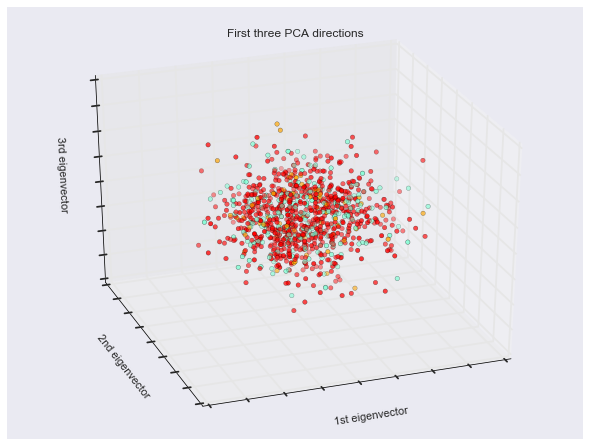

Percentage of variance explained: [ 0.26728779  0.25565678  0.24497929  0.23207613]


In [11]:
fig = plt.figure(figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
#X_reduced = PCA(n_components=3).fit_transform(iris.data)
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=Y,
           cmap=plt.cm.Paired)
ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])

plt.show()

print('Percentage of variance explained:',PCA_pipe.named_steps['pca'].explained_variance_ratio_)

The percentage of variance explained by each eigenvector is nearly identical! This is a huge warning sign that the data is very likely random.

In [12]:
Y[Y == 'Orange'] = 'Burnt Umber'

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


---

# Models
As instructed, let's try a few different classifiers. I'll demo below what happens if we fit a logistic regression, k-nearest neighbors and 

Let's first split the data into training and test portions in order to avoid overfitting.

In [13]:
#X_sc refers to the normalized set of independent variables X (already calculated above)
#Y refers to the vector of labels (Red, Aquamarine, Burnt Umber)
X_train, X_test, y_train, y_test = train_test_split(X_sc, Y, test_size=0.3, random_state=0)

### Logistic Regression

In [14]:
logreg = linear_model.LogisticRegression()
logreg.fit(X_train,y_train)
preds = logreg.predict(X_test)
probs = logreg.predict_proba(X_test)
logreg.score(X_test,y_test)

0.74333333333333329

In [15]:
#not a great score - what's going on?
print(preds)
print(probs)

['Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red'
 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red'
 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red'
 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red'
 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red'
 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red'
 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red'
 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red'
 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red'
 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red'
 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red'
 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red'
 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red'
 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'R

In [16]:
## just to confirm that the logistic regression is simply guessing Red every time...
y_test.value_counts(normalize = True)

Red            0.743333
Aquamarine     0.190000
Burnt Umber    0.066667
Name: Label, dtype: float64

In [17]:
logreg.coef_

array([[-0.12586947,  0.0656063 , -0.06467545, -0.0238423 ],
       [-0.0670186 ,  0.10649579,  0.15963331, -0.1449776 ],
       [ 0.12955056, -0.08789108,  0.01062486,  0.06172246]])

I played around with the parameters on the logistic regression (changing C between small and large) but in the end, the coefficients are so weak on the different classes that the logistic regression will simply predict Red every time!

---
### K-Nearest Neighbors
Let's play around with K-nearest neighbors for different neighbors and weighting.

In [18]:
knn1 = KNeighborsClassifier(n_neighbors = 5, weights = 'distance')
knn1.fit(X_train,y_train)
knn1.score(X_test,y_test)

0.66333333333333333

Our predictivity is worse than if we just guessed Red every time!

In [19]:
knn1_preds = knn1.predict(X_test)
print(knn1_preds)

['Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red'
 'Aquamarine' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red'
 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Aquamarine' 'Red' 'Red' 'Red' 'Red'
 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red'
 'Red' 'Red' 'Red' 'Aquamarine' 'Aquamarine' 'Red' 'Red' 'Red' 'Red' 'Red'
 'Red' 'Red' 'Red' 'Red' 'Red' 'Aquamarine' 'Red' 'Red' 'Red' 'Aquamarine'
 'Aquamarine' 'Red' 'Red' 'Red' 'Red' 'Burnt Umber' 'Red' 'Red' 'Red' 'Red'
 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Aquamarine'
 'Red' 'Red' 'Red' 'Red' 'Aquamarine' 'Aquamarine' 'Red' 'Red' 'Red'
 'Aquamarine' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Aquamarine' 'Red'
 'Burnt Umber' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Aquamarine' 'Red'
 'Red' 'Red' 'Red' 'Red' 'Red' 'Aquamarine' 'Red' 'Red' 'Red' 'Red' 'Red'
 'Red' 'Red' 'Red' 'Aquamarine' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red'
 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' '

Basically no predictions of Burnt Umber because of infrequency in data. What if we reduce number of required neighbors?

In [20]:
knn2 = KNeighborsClassifier(n_neighbors = 3, weights = 'distance')
knn2.fit(X_train,y_train)
knn2.score(X_test,y_test)

0.59999999999999998

In [21]:
knn2_preds = knn2.predict(X_test)
print(knn2_preds)

['Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red'
 'Aquamarine' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red'
 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Aquamarine' 'Red' 'Red' 'Red'
 'Aquamarine' 'Red' 'Red' 'Red' 'Aquamarine' 'Red' 'Red' 'Aquamarine' 'Red'
 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Aquamarine' 'Aquamarine' 'Red'
 'Red' 'Red' 'Red' 'Red' 'Red' 'Aquamarine' 'Red' 'Red' 'Red' 'Aquamarine'
 'Red' 'Red' 'Red' 'Red' 'Aquamarine' 'Red' 'Red' 'Aquamarine'
 'Burnt Umber' 'Burnt Umber' 'Red' 'Red' 'Red' 'Aquamarine' 'Red' 'Red'
 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red'
 'Red' 'Aquamarine' 'Aquamarine' 'Aquamarine' 'Red' 'Red' 'Aquamarine'
 'Red' 'Aquamarine' 'Burnt Umber' 'Red' 'Red' 'Red' 'Red' 'Aquamarine'
 'Red' 'Burnt Umber' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Aquamarine'
 'Red' 'Red' 'Red' 'Aquamarine' 'Red' 'Red' 'Aquamarine' 'Red' 'Red'
 'Aquamarine' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'R

In [22]:
knn3 = KNeighborsClassifier(n_neighbors = 9, weights = 'distance')
knn3.fit(X_train,y_train)
knn3.score(X_test,y_test)

0.70333333333333337

If we increase the number of neighbors used, skill increases, but only because all of our guesses converge on all Red.

In [23]:
knn3_preds = knn3.predict(X_test)
print(knn3_preds)

['Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red'
 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red'
 'Red' 'Red' 'Red' 'Red' 'Red' 'Aquamarine' 'Red' 'Red' 'Red' 'Red' 'Red'
 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red'
 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red'
 'Red' 'Red' 'Aquamarine' 'Red' 'Red' 'Red' 'Red' 'Aquamarine' 'Red' 'Red'
 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red'
 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Aquamarine'
 'Aquamarine' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red'
 'Red' 'Red' 'Red' 'Burnt Umber' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red'
 'Aquamarine' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red'
 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red'
 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red'
 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 

In summary, none of this should be a surprise given the total lack of clustering apparent in exploring the data, but k-nearest neighbors fails to achieve any extra predictivity.

---
### Random Forest
No success with other methods so far, but let's try a random forest classifier just to try it out.

In [48]:
forest = RandomForestClassifier(n_estimators = 1000)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Are any features of particular importance in successfull trees? The answer is clearly no:

In [49]:
print(forest.feature_importances_)

[ 0.24879467  0.24548602  0.25085786  0.25486144]


Not only that, but we still can't beat the level of skill achieved just by picking Red every time!

In [53]:
forest_preds = forest.predict(X_test)
fsc = forest.score(X_test,y_test)
print(fsc)
print(forest_preds)

0.726666666667
['Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red'
 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red'
 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red'
 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red'
 'Red' 'Aquamarine' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red'
 'Red' 'Red' 'Burnt Umber' 'Red' 'Red' 'Red' 'Red' 'Aquamarine' 'Red' 'Red'
 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red'
 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Aquamarine'
 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red'
 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Aquamarine'
 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Aquamarine' 'Red'
 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red'
 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red' 'Red'
 'Red' 'Red' 'Red' 'Red' 'Red

---
## In conclusion...
I would tell my boss that there is no way based on the four given features of predicting the class of a point. Exploration of the distribution of the data with joint plots and PCA suggests no consistent modes of variability between features, and no difference in distribution between classes. Furthermore, a logistic regression model, k-nearest neighbors and a random trees classifier were all unable to achieve any skill whatsoever in assigning test data to classes based on training data.

---
# Cost Function/Reward
Let's go ahead anyway and implement part c, in which we assign a cost function and reward to classification of each point.

In [73]:
data['cost'] = data['Feat 1']+data['Feat 2']+data['Feat 3']+data['Feat 4']

In [112]:
data['reward'] = 5
data.ix[data['Label'] == 'Aquamarine', 'reward'] = 10
data.ix[data['Label'] == 'Burnt Umber', 'reward'] = 50

In [113]:
data

,ID,Feat 1,Feat 2,Feat 3,Feat 4,Label,cost,reward,profit,predict_red
0,1,10.526413,5.680796,1.661569,0.167528,Burnt Umber,18.036306,50,31.963694,-18.036306
1,2,15.023991,5.471672,0.897001,0.669878,Red,22.062543,5,-17.062543,-17.062543
2,3,16.021447,-1.501333,1.902509,0.351208,Red,16.773831,5,-11.773831,-11.773831
3,4,14.425902,6.429031,1.025405,0.528408,Aquamarine,22.408746,10,-12.408746,-22.408746
4,5,11.547150,-4.699529,0.337308,0.011619,Red,7.196548,5,-2.196548,-2.196548
5,6,17.602117,4.357428,0.160076,0.148566,Red,22.268187,5,-17.268187,-17.268187
6,7,15.426342,-1.529764,0.395403,0.330656,Aquamarine,14.622636,10,-4.622636,-14.622636
7,8,12.468030,-3.472323,-0.800505,0.655059,Red,8.850261,5,-3.850261,-3.850261
8,9,16.325586,0.768771,0.482587,0.837411,Aquamarine,18.414355,10,-8.414355,-18.414355
9,10,12.061068,0.344169,-0.427699,0.812735,Aquamarine,12.790273,10,-2.790273,-12.790273


In [114]:
print('Mean Cost by Class:', data.groupby('Label')['cost'].mean())
print('\nStd Dev of Cost by Class:', data.groupby('Label')['cost'].std())

Mean Cost by Class: Label
Aquamarine     16.498375
Burnt Umber    16.384683
Red            16.413059
Name: cost, dtype: float64

Std Dev of Cost by Class: Label
Aquamarine     4.355816
Burnt Umber    5.038435
Red            4.707608
Name: cost, dtype: float64


As expected, the above shows that the mean cost of making a prediction is the same for any of the classes, so we can just focus on the reward.

In [115]:
freq = data['Label'].value_counts(normalize = True)
print(freq)

Red            0.72
Aquamarine     0.22
Burnt Umber    0.06
Name: Label, dtype: float64


In [116]:
rewards = {'Red': 5, 'Aquamarine': 10, 'Burnt Umber': 50}

In [117]:
expected_value = {}

for cls in ['Red','Aquamarine','Burnt Umber']:
    expected_value[cls] = freq[cls]*rewards[cls] - data['cost'].mean()
    print('Expected value of predicting',cls,':',expected_value[cls])

Expected value of predicting Red : -12.8301257073
Expected value of predicting Aquamarine : -14.2301257073
Expected value of predicting Burnt Umber : -13.4301257073


So given the expected value of each type of prediction, we're best off predicting Red for every point, with a net EV of -12.83.

As far as question d (determining a confidence interval), I don't understand the problem as stated, but I'll use a bootstrap resampling method anyway to show the standard deviation of the mean if we resample the data 1000 times.

In [136]:
data['predict_red'] = -data['cost']
data.ix[data['Label'] == 'Red', 'predict_red'] = data['predict_red'] + 5
data.head()

,ID,Feat 1,Feat 2,Feat 3,Feat 4,Label,cost,reward,profit,predict_red
0,1,10.526413,5.680796,1.661569,0.167528,Burnt Umber,18.036306,50,31.963694,-18.036306
1,2,15.023991,5.471672,0.897001,0.669878,Red,22.062543,5,-17.062543,-17.062543
2,3,16.021447,-1.501333,1.902509,0.351208,Red,16.773831,5,-11.773831,-11.773831
3,4,14.425902,6.429031,1.025405,0.528408,Aquamarine,22.408746,10,-12.408746,-22.408746
4,5,11.547150,-4.699529,0.337308,0.011619,Red,7.196548,5,-2.196548,-2.196548


In [137]:
## sanity check
print(data['predict_red'].mean())

-12.830125707276993


In [142]:
niter = 1000
means = np.zeros([1000,])

for i in range(1000):
    means[i] = resample(data['predict_red']).mean()
    
ci = np.percentile(means,[2.5,97.5])
print('95% confidence interval of mean outcome of all-Red strategy:',ci[0],'to',ci[1])

95% confidence interval of mean outcome of all-Red strategy: -13.1256050775 to -12.5130285417
